Importing libraries

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import random
!pip install primePy
from primePy import primes
from PIL import Image
import math
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

Utility functions

In [ ]:
def modinv(a, m):
    # Extended Euclidean algorithm to compute the modular inverse
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('Modular inverse does not exist')
    else:
        return x % m
# GCD using extended euclidean
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

In [ ]:
# Returns the keys required for RSA
def generateKeys():
  # Generating primes p and q
  lower_bound = 10**4
  upper_bound = (10**5) - 1

  while True:
    p = random.randint(lower_bound, upper_bound)
    q = random.randint(lower_bound, upper_bound)

    if primes.check(p) and primes.check(q) and p != q:
      # print(p, " ", q)
      break

  # Calculating 'n' & phi_n
  n = p*q
  phi_n = (p-1) * (q-1)

  # Generating 'e' & 'd'

  # e - public key (part of) --- 1 < e < phi_n && e is coprime to phi_n
  e = 2
  while math.gcd(phi_n, e) != 1:
    e = random.randint(2, phi_n-1)

  # d - private key --- e^-1 mod phi_n
  d = modinv(e, phi_n)

  return p, q, n, phi_n, e, d

Reading an image

Enter file name (with full path): swift.jpg


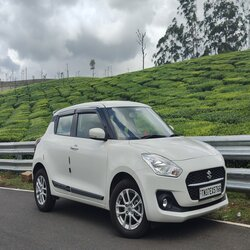

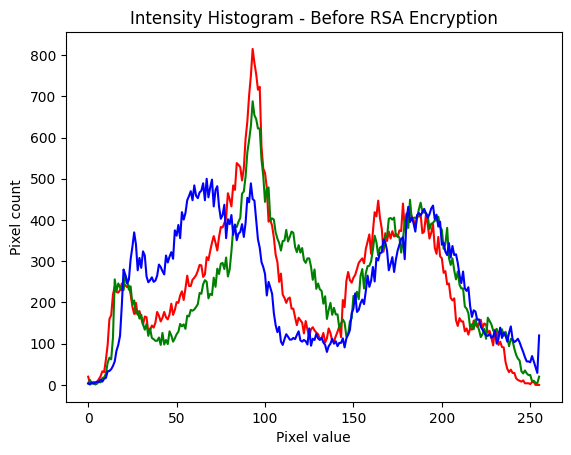

In [ ]:
input_file = input('Enter file name (with full path): ')
#image = cv2.imread("/content/drive/MyDrive/SEM_6/CG Lab/Package/swift.jpg")
image = cv2.imread(input_file)

# Displaying the image
cv2_imshow(image)

# Displaying histogram
# Args - Image, Color channel, Mask (to obtain for part of image), No. of value bins, Range to consider
hist_red = cv2.calcHist([image], [2], None, [256], [0,256])
hist_green = cv2.calcHist([image], [1], None, [256], [0,256])
hist_blue = cv2.calcHist([image], [0], None, [256], [0,256])
plt.plot(hist_red, color='red')
plt.plot(hist_green, color='green')
plt.plot(hist_blue, color='blue')

plt.title('Intensity Histogram - Before RSA Encryption')
plt.xlabel('Pixel value')
plt.ylabel('Pixel count')
plt.savefig('original_histogram.jpg')
plt.show()


Pre-processing the image

In [ ]:
height, width = image.shape[:2]

flat_img = image.reshape((-1, )) # -1 automatically infers correct conversion to 1-D

RSA Encryption

p:  37861
q:  40759
n:  1543176499
phi_n:  1543097880
e:  140248927
d:  1144657783
e*d:  160537025847948841
e*d mod phi_n:  1


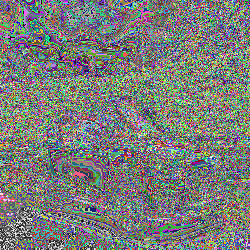

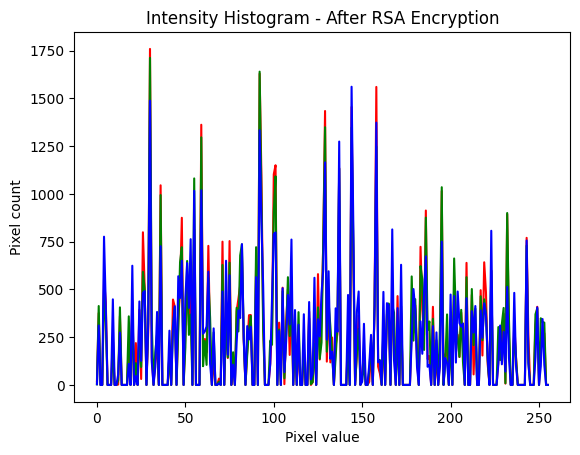

In [ ]:
p, q, n, phi_n, e, d = generateKeys()
print('p: ', p)
print('q: ', q)
print('n: ', n)
print('phi_n: ', phi_n)
print('e: ', e)
print('d: ', d)

print('e*d: ', e*d)
print('e*d mod phi_n: ', (e*d)%phi_n)
# pow() with 3 args does modular exponentiation
# RSA Encryption: Enc(M) = M^e mod n
encrypted_img_text = [pow(int(flat_img[i]), e, n) for i in range(len(flat_img))]
encrypted_img_text = np.array(encrypted_img_text)

# Converting encrypted text to image
encrypted_img = encrypted_img_text % 256
encrypted_img = encrypted_img_text.astype(np.uint8)

# Displaying encrypted image
encrypted_img = encrypted_img.reshape(height, width, 3)
cv2.imwrite("rsa_encrypted_img.jpg", encrypted_img)
cv2_imshow(encrypted_img)

# Displaying histogram
hist_red = cv2.calcHist([encrypted_img], [2], None, [256], [0,256])
hist_green = cv2.calcHist([encrypted_img], [1], None, [256], [0,256])
hist_blue = cv2.calcHist([encrypted_img], [0], None, [256], [0,256])
plt.plot(hist_red, color='red')
plt.plot(hist_green, color='green')
plt.plot(hist_blue, color='blue')

plt.title('Intensity Histogram - After RSA Encryption')
plt.xlabel('Pixel value')
plt.ylabel('Pixel count')
plt.savefig('rsa_histogram.jpg')
plt.show()

RSA Decryption

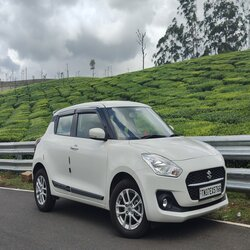

In [ ]:
# RSA Decryption: Dec(M) = M^d mod n
decrypted_img_text = [pow(int(encrypted_img_text[i]), int(d), n)%256 for i in range(len(encrypted_img_text))]
decrypted_img_text = np.array(decrypted_img_text)

decrypted_img = decrypted_img_text.astype(np.uint8)

decrypted_img = decrypted_img_text.reshape(height, width, 3)
cv2.imwrite("rsa_decrypted_img.jpg", decrypted_img)
cv2_imshow(decrypted_img)

Chaos in cryptography :

In cryptography, chaos refers to the use of chaotic systems or chaotic behavior to enhance the security of cryptographic algorithms. Chaos is a mathematical concept where even small changes in initial conditions can lead to drastically different outcomes over time. This inherent unpredictability can be leveraged to create cryptographic techniques that are resistant to attacks.

**Why Chaos Maps for encryption?**

1. Traditional encrypting mechanisms (AES and RSA) exhibit some drawbacks and weakness in the encryption of digital images and high computing

2. Large computational time for large images

3. High computing power for large images

Chaotic maps :

Chaotic maps are mathematical functions that are utilized to enhance the security of cryptographic algorithms. These maps exploit the inherent unpredictability and complexity found in chaotic systems to generate randomness or to scramble data

# BAKER's MAP

In [ ]:
# Folding a row - first half of row becomes second half of row
# Stretching - Pixel coordinate values are multiplied by a constant

def bakers_map(block, folding_factor, stretching_factor):
  x, y, channels = block.shape
  new_block = np.zeros_like(block) # Zeroes of shape 'block'

  for i in range(x):
    for j in range(y):
      new_coords = ((folding_factor * i)%x, (stretching_factor * j)%y)
      new_block[new_coords[0], new_coords[1], :] = block[i, j, :] # ':' Select all color channels
  return new_block

def bakers_encrypt(image, folding_factor, stretching_factor, block_size):
  rows, cols, channels = image.shape

  enc_image = np.zeros_like(image)

  for i in range(0, rows, block_size):
    for j in range(0, cols, block_size):
      block = image[i:i+block_size, j:j+block_size, :]
      enc_block = bakers_map(block, folding_factor, stretching_factor)
      enc_image[i:i+block_size, j:j+block_size, :] = enc_block

  return enc_image

def bakers_decrypt(enc_image, folding_factor, stretching_factor, block_size):
  rows, cols, channels = enc_image.shape

  dec_image = np.zeros_like(enc_image)

  inv_fold_factor = modinv(folding_factor, rows)
  inv_stretch_factor = modinv(stretching_factor, cols)

  for i in range(0, rows, block_size):
    for j in range(0, cols, block_size):
      block = enc_image[i:i+block_size, j:j+block_size, :]
      dec_block = bakers_map(block, inv_fold_factor, inv_stretch_factor)
      dec_image[i:i+block_size, j:j+block_size, :] = dec_block
  return dec_image

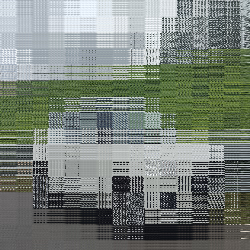

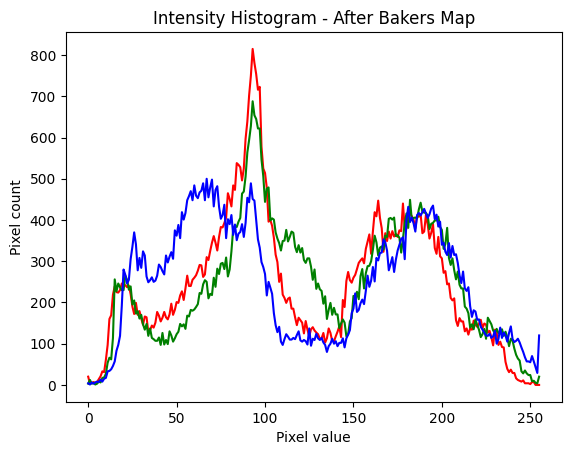

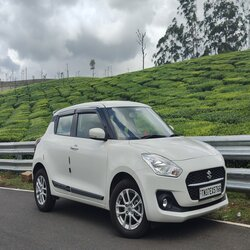

In [ ]:
bakers_img = cv2.imread(input_file)

# NOTE: folding_factor must be coprime with no. of rows
#       stretching_factor must be coprime with no. of columns

folding_factor = 23
stretching_factor = 29
block_size = 16

enc_image = bakers_encrypt(bakers_img, folding_factor, stretching_factor, block_size)

cv2_imshow(enc_image)
cv2.imwrite('bakers_encrypted.jpg', enc_image)

# Displaying histogram
hist_red = cv2.calcHist([enc_image], [2], None, [256], [0,256])
hist_green = cv2.calcHist([enc_image], [1], None, [256], [0,256])
hist_blue = cv2.calcHist([enc_image], [0], None, [256], [0,256])
plt.plot(hist_red, color='red')
plt.plot(hist_green, color='green')
plt.plot(hist_blue, color='blue')

plt.title('Intensity Histogram - After Bakers Map')
plt.xlabel('Pixel value')
plt.ylabel('Pixel count')
plt.savefig('bakers_histogram.jpg')
plt.show()

dec_img = bakers_decrypt(enc_image, folding_factor, stretching_factor, block_size)

cv2_imshow(dec_img)

# LOGISTIC MAP

Recursive formula : x[n+1] = r.x[n].(1- x[n])

x[n] -> Population size at time n
x[n+1] -> Population size at time step n+1
r -> Parameter to control rate of population growth
Range of x[n] values - [0, 1]

In [ ]:
def logistic_map(x, r):
  return r * x * (1-x)

def logistic_generate_key(init_val, r, key_len):
  key = [init_val]
  for i in range(key_len - 1):
    key.append(logistic_map(key[-1], r))
  return np.array(key)

def logistic_encrypt(image, key):
    encrypted_image = np.zeros_like(image)
    rows, cols, channels = image.shape
    key_index = 0
    for i in range(rows):
        for j in range(cols):
            for k in range(channels):
                pixel_value = image[i, j, k]
                key_value = key[key_index]
                encrypted_pixel_value = pixel_value ^ int(key_value * 255) # XOR pixel value with current pixel value and scaled key value
                encrypted_image[i, j, k] = encrypted_pixel_value
                key_index = (key_index + 1) % len(key)
    return encrypted_image

def logistic_decrypt(encrypted_image, key):
    decrypted_image = np.zeros_like(encrypted_image)
    rows, cols, channels = encrypted_image.shape
    key_index = 0
    for i in range(rows):
        for j in range(cols):
            for k in range(channels):
                encrypted_pixel_value = encrypted_image[i, j, k]
                key_value = key[key_index]
                decrypted_pixel_value = encrypted_pixel_value ^ int(key_value * 255)
                decrypted_image[i, j, k] = decrypted_pixel_value
                key_index = (key_index + 1) % len(key)
    return decrypted_image

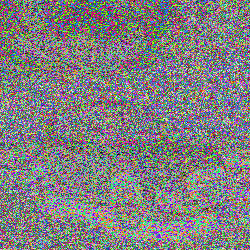

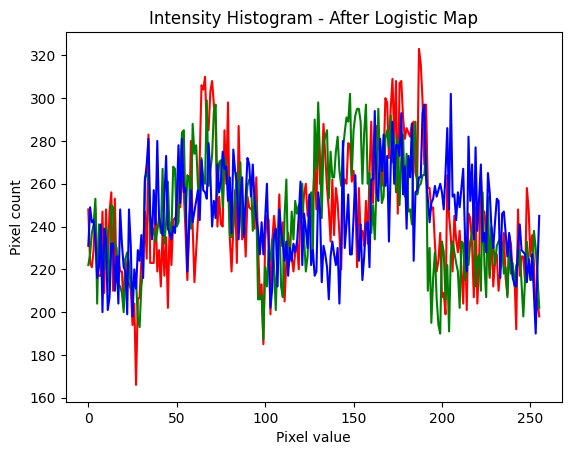

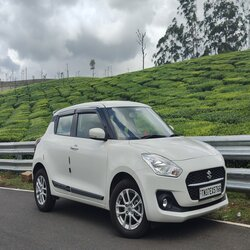

In [ ]:
logistic_image = cv2.imread(input_file)

init_val = 0.5
r = 3.9

# Shape - (Height, Width, Color channels)
key_length = logistic_image.shape[0] * logistic_image.shape[1] * logistic_image.shape[2]

key = logistic_generate_key(init_val, r, key_length)

enc_img = logistic_encrypt(logistic_image, key)

cv2.imwrite('logistic_encrypted.jpg', enc_img)
cv2_imshow(enc_img)

# Displaying histogram
hist_red = cv2.calcHist([enc_img], [2], None, [256], [0,256])
hist_green = cv2.calcHist([enc_img], [1], None, [256], [0,256])
hist_blue = cv2.calcHist([enc_img], [0], None, [256], [0,256])
plt.plot(hist_red, color='red')
plt.plot(hist_green, color='green')
plt.plot(hist_blue, color='blue')

plt.title('Intensity Histogram - After Logistic Map')
plt.xlabel('Pixel value')
plt.ylabel('Pixel count')
plt.savefig('logisitic_histogram.jpg')
plt.show()

dec_img = logistic_decrypt(enc_img, key)

cv2_imshow(dec_img)

# Arnold Cat Map

It applies a tranform on the image that essentially shuffles the pixels by stretching anf folding the image.


1.   x-coord modification: (x+y) % rows
2.   y-coord modification: (x+2*y) % rows





In [ ]:
def arnold_cat_transform(img, num):
    rows, cols, channels = img.shape

    img_arnold = np.copy(img)

    for x in range(rows):
        for y in range(cols):
            img_arnold[x][y] = img[(x+y)%rows][(x+2*y)%rows]
    return img_arnold

def arnold_encrypt(img, key):
    # Key - No. of iterations to repeat the transform
    for i in range (0,key):
        img = arnold_cat_transform(img, i)

    return img

def arnold_decrypt(img, key):
    rows, cols, channels = img.shape

    # Finds the no. of iterations to decrypt it
    decrypt_iter = rows
    if (rows%2==0) and 5**int(round(math.log(rows/2,5))) == int(rows/2):
        decrypt_iter = 3*rows
    elif 5**int(round(math.log(rows,5))) == int(rows):
        decrypt_iter = 2*rows
    elif (rows%6==0) and  5**int(round(math.log(rows/6,5))) == int(rows/6):
        decrypt_iter = 2*rows
    else:
        decrypt_iter = int(12*rows/7)

    for i in range(key,decrypt_iter):
        img = arnold_cat_transform(img, i)

    return img

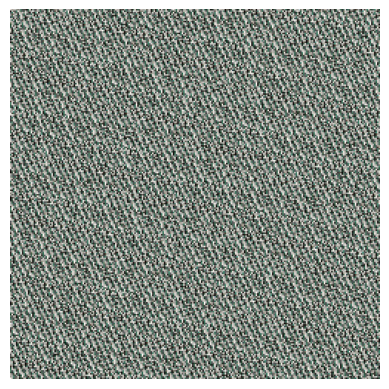

In [ ]:
arnold_img = cv2.imread(input_file)
key = 20

enc_img = arnold_encrypt(arnold_img, 20)

cv2.imwrite('arnold_cat_encrypted.jpg', enc_img)
plt.imshow(enc_img)
plt.axis('off')
plt.show()

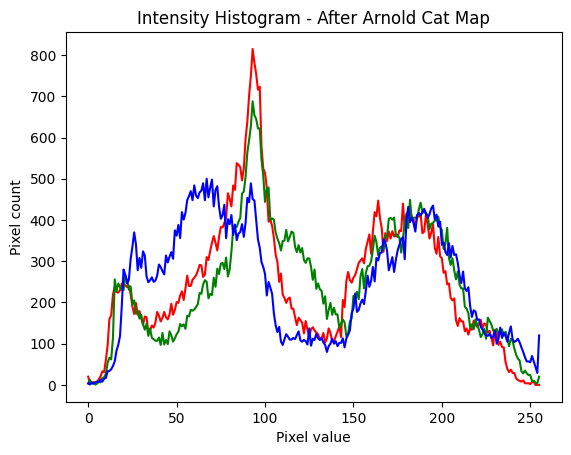

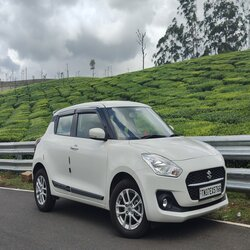

In [ ]:
# Displaying histogram for Arnold Cat encrypted image
hist_red = cv2.calcHist([enc_img], [2], None, [256], [0,256])
hist_green = cv2.calcHist([enc_img], [1], None, [256], [0,256])
hist_blue = cv2.calcHist([enc_img], [0], None, [256], [0,256])
plt.plot(hist_red, color='red')
plt.plot(hist_green, color='green')
plt.plot(hist_blue, color='blue')

plt.title('Intensity Histogram - After Arnold Cat Map')
plt.xlabel('Pixel value')
plt.ylabel('Pixel count')
plt.savefig('arnold_cat_histogram.jpg')
plt.show()

dec_img = arnold_decrypt(enc_img, key)

cv2_imshow(dec_img)